In [1]:
import sys
sys.path.append("/home3/p306982/Simulations/fscil/algorithms_benchmarks/")
import os

import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import copy
from tqdm import tqdm

from torch.utils.data import DataLoader, ConcatDataset
import torchaudio.transforms as T

# from torch_mate.data.utils import IncrementalFewShot

from neurobench.datasets import MSWC
from neurobench.datasets.MSWC_IncrementalLoader import IncrementalFewShot
from neurobench.examples.mswc_fscil.M5 import M5
from neurobench.models import TorchModel

from neurobench.examples.model_data.sparchSNNs import SNN
from neurobench.examples.model_data.sparchSNNs import RadLIFLayer

from neurobench.benchmarks import Benchmark
from neurobench.preprocessing import MFCCProcessor
from neurobench.preprocessing import S2SProcessor

from cl_utils import *

import numpy as np
import matplotlib.pyplot as plt
import argparse

In [2]:
ROOT = "//scratch/p306982/data/fscil/FSCIL_subset/" #"data/MSWC/"
NUM_WORKERS = 8
BATCH_SIZE = 256
NUM_REPEATS = 1
SPIKING = True
PRE_TRAIN = False
SOFT_DELTA = False
S2S_THRESH = 1.0 #1.0

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == torch.device("cuda"):
    PIN_MEMORY = True
else:
    PIN_MEMORY = False

# Define MFCC pre-processing 
n_fft = 512
win_length = None
hop_length = 240
n_mels = 20
n_mfcc = 20

if SPIKING:
    encode = S2SProcessor(device, transpose=False, soft_delta=SOFT_DELTA)
    config_change = {"sample_rate": 48000,
                     "hop_length": 240}
    encode.configure(threshold=S2S_THRESH, **config_change)
else:
    encode = MFCCProcessor(
        sample_rate=48000,
        n_mfcc=n_mfcc,
        melkwargs={
            "n_fft": n_fft,
            "n_mels": n_mels,
            "hop_length": hop_length,
            "mel_scale": "htk",
            "f_min": 20,
            "f_max": 4000,
        },
        device = device
    )



squeeze = lambda x: (x[0].squeeze(), x[1])
out2pred = lambda x: torch.argmax(x, dim=-1)
to_device = lambda x: (x[0].to(device), x[1].to(device))

In [4]:
# PT_MODEL = "/home3/p306982/Simulations/fscil/algorithms_benchmarks/neurobench/examples/mswc_fscil/model_data/SPmodel_shorttrain"
# PT_MODEL = "//scratch/p306982/data/fscil/FSCIL_subset/SpikingModel_ep50_0.001_bs64_Nhidden1024_simple"
PT_MODEL = "/home3/p306982/Simulations/fscil/algorithms_benchmarks/neurobench/examples/mswc_fscil/model_data/SPmodel_25_full"


In [5]:
if SPIKING:
    model = torch.load(PT_MODEL, map_location=device)
    model = TorchModel(model)
    model.add_activation_module(RadLIFLayer)
else:
    model = M5(n_input=20, stride=2, n_channel=256, 
            n_output=200, input_kernel=4, pool_kernel=2, drop=True).to(device)
    load_dict = torch.load("/home3/p306982/Simulations/fscil/algorithms_benchmarks/neurobench/examples/mswc_fscil/model_data/mswc_mfcc_cnn", 
                        map_location=device).state_dict()
    model.load_state_dict(load_dict)
    model = TorchModel(model)

In [10]:
V0_clone = model.net.snn[0].V.weight.clone()
model.net.snn[0].V.weight.data = V0_clone.t()

In [11]:
V1_clone = model.net.snn[1].V.weight.clone()
model.net.snn[1].V.weight.data = V1_clone.t()

In [13]:
all_evals = []
all_query = []

In [6]:
model.net

SNN(
  (snn): ModuleList(
    (0): RadLIFLayer(
      (W): Linear(in_features=20, out_features=1024, bias=False)
      (V): Linear(in_features=1024, out_features=1024, bias=False)
      (norm): BatchNorm1d(1024, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
      (drop): Dropout(p=0.1, inplace=False)
    )
    (1): RadLIFLayer(
      (W): Linear(in_features=1024, out_features=1024, bias=False)
      (V): Linear(in_features=1024, out_features=1024, bias=False)
      (norm): BatchNorm1d(1024, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
      (drop): Dropout(p=0.1, inplace=False)
    )
    (2): ReadoutLayer(
      (W): Linear(in_features=1024, out_features=200, bias=False)
      (norm): BatchNorm1d(200, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
      (drop): Dropout(p=0.1, inplace=False)
    )
  )
)

In [7]:
eval_model = copy.deepcopy(model)

eval_accs = []
query_accs = []
act_sparsity = []
syn_ops_dense = []
syn_ops_macs = []

# Get base test set for evaluation
base_test_set = MSWC(root=ROOT, subset="base", procedure="testing")
test_loader = DataLoader(base_test_set, batch_size=256, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

# Define an arbitrary resampling as an example of pre-processor to feed to the Benchmark object
eval_model.net.eval()

# Metrics
static_metrics = ["model_size", "connection_sparsity"]
data_metrics = ["classification_accuracy", "activation_sparsity", "synaptic_operations"]

# Define benchmark object
benchmark_all_test = Benchmark(eval_model, metric_list=[static_metrics, data_metrics], dataloader=test_loader, 
                    preprocessors=[to_device, encode, squeeze], postprocessors=[])

benchmark_new_classes = Benchmark(eval_model, metric_list=[[],["classification_accuracy"]], dataloader=test_loader,
                    preprocessors=[to_device, encode, squeeze], postprocessors=[])

# Define specific post-processing with masking on the base classes
mask = torch.full((200,), float('inf')).to(device)
mask[torch.arange(0,100, dtype=int)] = 0
out_mask = lambda x: x - mask

In [25]:
sample = next(iter(test_loader))

data, target = encode(to_device(sample))

spikes = data[50].detach().cpu().numpy()

# Get the indices of positive and negative spikes
positive_indices = np.where(spikes == 1)
negative_indices = np.where(spikes == -1)

In [26]:
torch.mean(torch.abs(data))

tensor(0.3574, device='cuda:0')

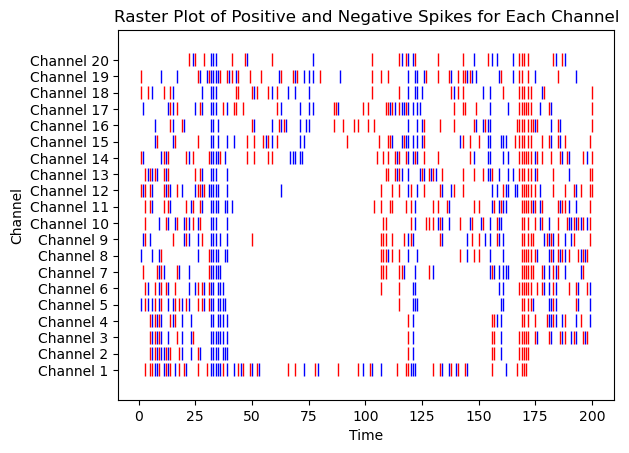

<Figure size 6400x4800 with 0 Axes>

In [27]:
# Get the indices of positive and negative spikes for each channel
positive_indices = np.where(spikes == 1)
negative_indices = np.where(spikes == -1)

# Plot positive spikes in blue and negative spikes in red for each channel
for channel in range(spikes.shape[1]):
    positive_channel_indices = positive_indices[0][positive_indices[1] == channel]
    negative_channel_indices = negative_indices[0][negative_indices[1] == channel]
    
    plt.eventplot(positive_channel_indices, linelengths=0.8, colors='blue', label=f'Channel {channel + 1} Positive', lineoffsets=channel + 1, linewidths=1)
    plt.eventplot(negative_channel_indices, linelengths=0.8, colors='red', label=f'Channel {channel + 1} Negative', lineoffsets=channel + 1, linewidths=1)

# Customize the plot
plt.title('Raster Plot of Positive and Negative Spikes for Each Channel')
plt.xlabel('Time')
plt.ylabel('Channel')
# plt.legend()
plt.yticks(np.arange(1, spikes.shape[1] + 1), [f'Channel {i + 1}' for i in range(spikes.shape[1])])
plt.figure(dpi=1000)
plt.show()


In [7]:
base_train_set = MSWC(root=ROOT, subset="base", procedure="training")
train_loader = DataLoader(base_train_set, batch_size=500, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

In [8]:
import torch.nn as nn

# protos = {}
proto_out = nn.Linear(1024, 200, bias=True).to(device)
proto_out.weight.data = eval_model.net.snn[-1].W.weight.data

for data, target in train_loader:

    data, target = encode((data.to(device), target.to(device)))
    data = data.squeeze()
    class_id = target[0]

    features = eval_model.net.snn[0](data)
    features = eval_model.net.snn[1](features)

    mean = torch.sum(features, dim=[0,1])/500
    proto_out.weight.data[class_id] = 2*mean
    proto_out.bias.data[class_id] = -torch.matmul(mean, mean.t())/features.shape[1]


    del data
    del features
    del mean


eval_model.net.snn[-1].W = proto_out

In [8]:
PROTOTYPES = True

In [12]:
print(f"Session: 0")
if PROTOTYPES:
    pre_train_results = benchmark_all_test.run(postprocessors=[out_mask, F.softmax, out2pred, torch.squeeze])
else:
    pre_train_results = benchmark_all_test.run(postprocessors=[out_mask, out2pred, torch.squeeze])
print("Base results:", pre_train_results)
eval_accs.append(pre_train_results['classification_accuracy'])
act_sparsity.append(pre_train_results['activation_sparsity'])
syn_ops_dense.append(pre_train_results['synaptic_operations']['Dense'])
syn_ops_macs.append(pre_train_results['synaptic_operations']['Effective_MACs'])
print(f"The base accuracy is {eval_accs[-1]*100}%")

Session: 0
Running benchmark


100%|██████████| 40/40 [00:25<00:00,  1.60it/s]

Base results: {'model_size': 13553592, 'connection_sparsity': 0.0006, 'classification_accuracy': 0.011899999999999999, 'activation_sparsity': 0.8528586974793998, 'synaptic_operations': {'Effective_MACs': 0.0, 'Effective_ACs': 98928732.0815, 'Dense': 677572608.0}}
The base accuracy is 1.19%


In [10]:
NORMALIZE = False
RESET = "random"
EVAL_LR = 0.007
EVAL_SHOTS = 5
SAMPLED_STEPS = 0
EVAL_EPOCHS = 1

In [11]:
import random
random.seed(10)
np.random.seed(10)
torch.manual_seed(10)

few_shot_dataloader = IncrementalFewShot(n_way=10, k_shot=EVAL_SHOTS, 
                            root = ROOT,
                            query_shots=100,
                            support_query_split=(100,100),
                            samples_per_class=200)

# Saves shifted versions of 
eval_model.net.saved_weights = {}
pre_train_class = range(100)
if SPIKING:
    consolidate_weights(eval_model.net, eval_model.net.snn[-1].W, pre_train_class, normalize=NORMALIZE)
else:
    consolidate_weights(eval_model.net, eval_model.net.output, pre_train_class, normalize=NORMALIZE)


few_shot_optimizer = torch.optim.SGD(eval_model.net.parameters(), lr=EVAL_LR, momentum=0.9, weight_decay=0.0005)

In [12]:
iter_loader = iter(few_shot_dataloader)

In [19]:
support, query, query_classes = next(iter_loader)

In [15]:
query_classes

[192, 190, 197, 199, 198, 191, 196, 195, 194, 193]

### ProtoNET

In [29]:
# set_consolidate_weights(eval_model.net, eval_model.net.snn[-1].W) 

data = None
for X_shot, y_shot in support:
    if data is None:
        data = X_shot
        target = y_shot
    else:
        data = torch.cat((data,X_shot), 0)
        target = torch.cat((target,y_shot), 0)

data, target = encode((data.to(device), target.to(device)))
data = data.squeeze()

features = eval_model.net.snn[0](data)
features = eval_model.net.snn[1](features)
features.shape

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [30]:
query_classes[-10:]

[109, 105, 106, 103, 102, 108, 107, 100, 101, 104]

In [28]:
import torch.nn as nn

# proto_out = nn.Linear(1024, 200, bias=True).to(device)
# proto_out.weight.data = eval_model.net.snn[-1].W.weight.data

for index, class_id  in enumerate(query_classes[-10:]):
    mean = torch.sum(features[[i*10+index for i in range(EVAL_SHOTS)]], dim=[0,1])/EVAL_SHOTS
    eval_model.net.snn[-1].W.weight.data[class_id] = 2*mean
    eval_model.net.snn[-1].W.bias.data[class_id] = -torch.matmul(mean, mean.t())/(features.shape[1])

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [37]:
eval_model.net.snn[-1].W.bias

Parameter containing:
tensor([ 4.3638e-03, -2.7057e-02,  1.0268e-02,  1.8048e-02,  9.1156e-03,
        -1.1058e-02, -2.7756e-02, -8.1517e-04, -3.7394e-03, -1.8155e-02,
        -2.9735e-02, -1.7817e-02,  6.2673e-04,  1.3857e-02, -2.7372e-02,
        -2.5133e-02, -1.9607e-02, -2.9135e-02, -1.0613e-02, -2.9045e-02,
         3.6959e-03, -1.5498e-02, -1.7690e-02, -1.4257e-02, -7.8650e-03,
        -3.1193e-02, -2.2433e-02,  1.8530e-02,  1.3506e-02,  2.8631e-02,
         9.9968e-05,  2.5857e-02, -1.7531e-02,  1.1485e-02,  3.0773e-02,
        -9.6438e-03, -1.0937e-02,  2.5539e-02, -1.4220e-02,  1.8263e-02,
        -2.6293e-02, -3.0124e-03,  2.4544e-02,  7.6261e-03, -5.0354e-03,
        -9.5068e-04,  2.2120e-02,  2.7113e-03, -1.8897e-02,  2.4488e-03,
         2.2699e-02,  1.4470e-02, -1.5671e-02,  7.0390e-03, -2.4004e-02,
         2.8005e-02, -1.1541e-02, -1.8921e-02,  2.0799e-02, -2.4156e-02,
         9.3249e-03,  2.4992e-02, -1.2988e-02, -2.4207e-02, -5.0445e-03,
         5.7479e-04,  2.7040e

In [69]:
### Few Shot Learning phase ###
eval_model.net.train()
#eval_model.lat_features.eval()
if SPIKING:
    eval_model.net.snn[:-1].eval()
    freeze_below(eval_model.net, "none", only_conv=False)
    eval_model.net.snn[-1].W.weight.requires_grad = True
else:
    freeze_below(eval_model.net, "output", only_conv=False)
    eval_below(eval_model.net, "output")

if RESET=="zero":
    reset_weights(eval_model.net, eval_model.net.snn[-1].W, cur_class)
elif RESET=="random":
    if SPIKING:
        torch.nn.init.xavier_normal_(eval_model.net.snn[-1].W.weight)

# Set prior centered weights again after eventual resetting of all weights
set_consolidate_weights(eval_model.net, eval_model.net.snn[-1].W) 

cur_class = support[0][1].tolist()

In [70]:
cur_class = support[0][1].tolist()
eval_model.net.cur_j = examples_per_class(cur_class, 200, 5)


for n in range(EVAL_EPOCHS):

    # data = None
    # for X_shot, y_shot in support:
    #     if data is None:
    #         data = X_shot
    #         target = y_shot
    #     else:
    #         data = torch.cat((data,X_shot), 0)
    #         target = torch.cat((target,y_shot), 0)

# Update weigts over successive shots
    for X_shot, y_shot in support:
        few_shot_optimizer.zero_grad()

        data, target = encode((X_shot.to(device), y_shot.to(device)))
        data = data.squeeze()

        output = eval_model(data)
        
        if SAMPLED_STEPS:
            sampled_indexes = range(SAMPLED_STEPS, output.shape[1], SAMPLED_STEPS)
            loss = 0.0
            for t in sampled_indexes:
                loss += F.cross_entropy(output[:, t], target)
            loss = loss/len(sampled_indexes)
        else:
            loss = F.cross_entropy(output.squeeze(), target)
        loss.backward()
        few_shot_optimizer.step()

    if SPIKING:
        consolidate_weights(eval_model.net, eval_model.net.snn[-1].W, cur_class, normalize=NORMALIZE)
        set_consolidate_weights(eval_model.net, eval_model.net.snn[-1].W)
    else:
        consolidate_weights(eval_model.net, eval_model.net.output, cur_class)
        set_consolidate_weights(eval_model.net, eval_model.net.output)

## SNN Weights

In [16]:
PROTOTYPES = True
cur_class = support[0][1].tolist()

In [25]:
matrix2 = np.stack([proto.detach().cpu().numpy() for proto in protos.values()], axis=0)
matrix2.shape

(10, 1024)

BASE CLASSES:
Range: (0.0, 34.988003)
Mean: 1.2679935
Std: 2.7561233
1st SESSION CLASSES:


NameError: name 'matrix2' is not defined

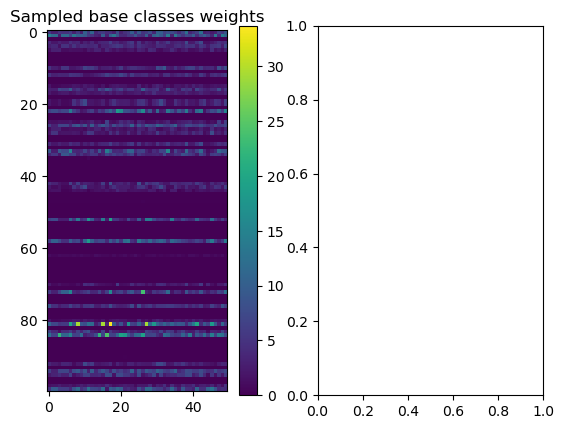

In [11]:
import numpy as np
import matplotlib.pyplot as plt

sample_hidden = np.random.randint(0, 256, 100)
sample_out = np.random.randint(0, 100, 50)

def plot_heatmap(matrix, title):
    plt.imshow(matrix, cmap='viridis', interpolation='nearest')
    plt.title(title)
    plt.colorbar()


# Assuming you have two weight matrices, matrix1 and matrix2
# Replace these with your actual matrices
weight_matrix = eval_model.net.snn[-1].W.weight.detach().cpu().numpy()

print("BASE CLASSES:")
print("Range:", (np.min(weight_matrix[:100]), np.max(weight_matrix[:100])))
print("Mean:", np.mean(weight_matrix[:100]))
print("Std:", np.std(weight_matrix[:100]))
print("1st SESSION CLASSES:")


# Use np.ix_ to create an open mesh of indices
matrix1 = weight_matrix[np.ix_(sample_out, sample_hidden)].transpose()
# Replace cur_class with the appropriate value
# if PROTOTYPES:
#     matrix2 = np.stack([proto.detach().cpu().numpy() for proto in protos.values()], axis=0)[:,sample_hidden].transpose()
#     print("Range:", (np.min(matrix2), np.max(matrix2)))
#     print("Mean:", np.mean(matrix2))
#     print("Std:", np.std(matrix2))
# else:
# matrix2 = weight_matrix[np.ix_(cur_class, sample_hidden)].transpose()
# print("Range:", (np.min(weight_matrix[cur_class]), np.max(weight_matrix[cur_class])))
# print("Mean:", np.mean(weight_matrix[cur_class]))
# print("Std:", np.std(weight_matrix[cur_class]))


# Plot the first heatmap
plt.subplot(1, 2, 1)
plot_heatmap(matrix1, 'Sampled base classes weights')

# Plot the second heatmap
plt.subplot(1, 2, 2)
plot_heatmap(matrix2, '1st session classes weights')

# Adjust layout for better visualization
plt.tight_layout()

# Show the plots
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


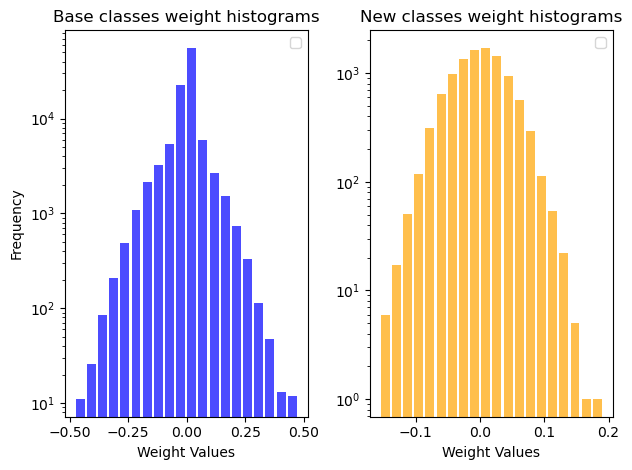

In [72]:
weight_matrix = eval_model.net.snn[-1].W.weight.detach().cpu().numpy()

# Use np.ix_ to create an open mesh of indices
matrix1 = weight_matrix[:100,].transpose()
# Replace cur_class with the appropriate value
matrix2 = weight_matrix[cur_class].transpose()



# Plot the first heatmap
plt.subplot(1, 2, 1)
plt.hist(matrix1.flatten(), bins=20, color='blue', alpha=0.7, log=True, rwidth=0.8)
plt.title('Base classes weight histograms')
plt.xlabel('Weight Values')
plt.ylabel('Frequency')
plt.legend()

# Plot the second heatmap
plt.subplot(1, 2, 2)
plt.hist(matrix2.flatten(), bins=20, color='orange', alpha=0.7, log=True, rwidth=0.8)
plt.title('New classes weight histograms')

# 
plt.xlabel('Weight Values')
# plt.ylabel('Frequency')
plt.legend()

# Adjust layout for better visualization
plt.tight_layout()

# Show the plots
plt.show()


In [18]:
benchmark = Benchmark(eval_model, metric_list=[[],["classification_accuracy"]], dataloader=test_loader,
                                preprocessors=[to_device, encode, squeeze], postprocessors=[])

### Testing phase ###
eval_model.net.eval()

# Define session dataloaders for query and query + base_test samples
query_loader = DataLoader(query, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

full_session_test_set = ConcatDataset([base_test_set, query])
full_session_test_loader = DataLoader(full_session_test_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

# Create a mask function to only consider accuracy on classes presented so far
session_classes = torch.cat((torch.arange(0,100, dtype=int), torch.IntTensor(query_classes))) 
mask = torch.full((200,), float('inf')).to(device)
mask[session_classes] = 0
out_mask = lambda x: x - mask

if SAMPLED_STEPS:
    sum_out = lambda x: torch.sum(x, dim=1)
    out_mask = lambda x: sum_out(x) - mask

# Run benchmark to evaluate accuracy of this specific session
session_results = benchmark.run(dataloader = full_session_test_loader, postprocessors=[out_mask, out2pred, torch.squeeze])
print(f"Session accuracy: {session_results['classification_accuracy']*100} %")


if PROTOTYPES:
    query_results = benchmark.run(dataloader = query_loader, postprocessors=[out_mask, F.softmax , out2pred, torch.squeeze])
    print(f"Accuracy on new classes: {query_results['classification_accuracy']*100} %")  
else:
    # Run benchmark on query classes only
    query_results = benchmark.run(dataloader = query_loader, postprocessors=[out_mask, out2pred, torch.squeeze])
    print(f"Accuracy on new classes: {query_results['classification_accuracy']*100} %")

Running benchmark


  0%|          | 0/43 [00:00<?, ?it/s]

100%|██████████| 43/43 [00:12<00:00,  3.39it/s]


Session accuracy: 82.16363635930149 %
Running benchmark


100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

Accuracy on new classes: 61.000000286102306 %


In [ ]:
NEW_NORM = 0.01
with torch.no_grad():
    output = eval_model.net.snn[-1].W.weight.detach()
    

    globalnorm = np.std(output.cpu().numpy()[cur_class])

    output = output * NEW_NORM/globalnorm

    eval_model.net.snn[-1].W.weight.data[cur_class] = output[cur_class]
    consolidate_weights(eval_model.net, eval_model.net.snn[-1].W, cur_class)

In [ ]:
base_test_set[i][0].to(device).reshape(1,1,-1).size()

torch.Size([1, 1, 48000])

In [ ]:
i = 2560

data, target = encode((base_test_set[i][0].to(device).reshape(1,1,-1), base_test_set[i][1]))
data = data.reshape(1,201,-1)
output = eval_model(data)
summed_batches = torch.sum(output,0).detach().cpu().numpy()

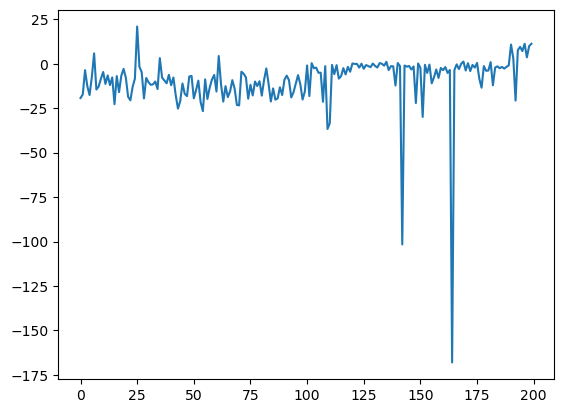

In [82]:
plt.plot(summed_batches)
plt.show()

In [46]:
full_session_test_loader = DataLoader(full_session_test_set, batch_size=100, num_workers=NUM_WORKERS)
act_dict = {}

with torch.no_grad():
    for X, y in full_session_test_loader:
        data, target = encode((X.to(device), int(y[0])))
        data = data.squeeze()

        output = eval_model(data)
        summed_batches = torch.sum(output,0)

        act_dict[target] = summed_batches.detach().cpu().numpy().copy()
        del output
        del summed_batches

OutOfMemoryError: CUDA out of memory. Tried to allocate 80.00 MiB (GPU 0; 19.50 GiB total capacity; 18.63 GiB already allocated; 65.88 MiB free; 19.17 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [47]:
del act_dict

## ANN Weights 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

sample_hidden = np.random.randint(0, 513, 50)
sample_out = np.random.randint(0, 101, 30)

def plot_heatmap(matrix, title):
    plt.imshow(matrix, cmap='viridis', interpolation='nearest')
    plt.title(title)
    plt.colorbar()


# Assuming you have two weight matrices, matrix1 and matrix2
# Replace these with your actual matrices
weight_matrix = eval_model.net.output.weight.detach().cpu().numpy()

# Use np.ix_ to create an open mesh of indices
matrix1 = weight_matrix[np.ix_(sample_out, sample_hidden)].transpose()
# Replace cur_class with the appropriate value
matrix2 = weight_matrix[np.ix_(cur_class, sample_hidden)].transpose()


# Plot the first heatmap
plt.subplot(1, 2, 1)
plot_heatmap(matrix1, 'Sampled base classes weights')

# Plot the second heatmap
plt.subplot(1, 2, 2)
plot_heatmap(matrix2, '1st session classes weights')

# Adjust layout for better visualization
plt.tight_layout()

# Show the plots
plt.show()

AttributeError: 'SNN' object has no attribute 'output'